In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [24]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [25]:
train_data=pd.read_table('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip')
test_data=pd.read_table('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip')

In [26]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


<AxesSubplot:>

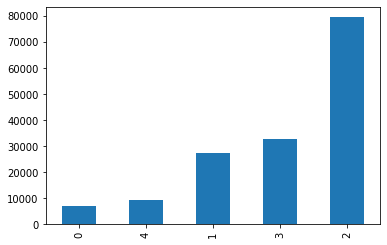

In [27]:
train_data.Sentiment.value_counts().sort_values().plot(kind = 'bar')

In [28]:
e_class_label_count=min(train_data.Sentiment.value_counts())
e_class_label_count

7072

In [29]:
x_labels=train_data[train_data['Sentiment']==1]
x_labels[:1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1


In [30]:
Non_bias_train_data=pd.DataFrame()
for i in (train_data['Sentiment'].unique()):
    temp_labels=train_data[train_data['Sentiment']==i]
    Non_bias_train_data=pd.concat([Non_bias_train_data,temp_labels[:e_class_label_count]])
Non_bias_train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
33,34,1,"the gander , some of which occasionally amuses...",1
47,48,1,but none of which amounts to much of a story,1
49,50,1,none of which amounts to much of a story,1
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1


<AxesSubplot:>

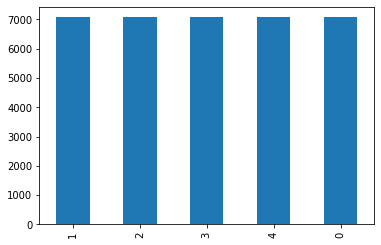

In [31]:
Non_bias_train_data.Sentiment.value_counts().sort_values().plot(kind = 'bar')

In [32]:
Non_bias_train_data.head(),Non_bias_train_data.shape

(    PhraseId  SentenceId                                             Phrase  \
 0          1           1  A series of escapades demonstrating the adage ...   
 33        34           1  the gander , some of which occasionally amuses...   
 47        48           1       but none of which amounts to much of a story   
 49        50           1           none of which amounts to much of a story   
 81        82           3  Even fans of Ismail Merchant 's work , I suspe...   
 
     Sentiment  
 0           1  
 33          1  
 47          1  
 49          1  
 81          1  ,
 (35360, 4))

In [33]:
Non_bias_train_data

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
33,34,1,"the gander , some of which occasionally amuses...",1
47,48,1,but none of which amounts to much of a story,1
49,50,1,none of which amounts to much of a story,1
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
...,...,...,...,...
155965,155966,8539,has turned out nearly 21\/2 hours of unfocused...,0
155967,155968,8539,"turned out nearly 21\/2 hours of unfocused , e...",0
155970,155971,8539,"of unfocused , excruciatingly tedious cinema",0
155971,155972,8539,"unfocused , excruciatingly tedious cinema",0


In [34]:
from sklearn.utils import shuffle
data=shuffle(Non_bias_train_data)

In [35]:
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test=train_test_split(Non_bias_train_data['Phrase'],Non_bias_train_data['Sentiment'].values,test_size=0.2)

In [36]:
x_train.shape,x_test.shape

((28288,), (7072,))

In [37]:
y_true=y_test

In [38]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [40]:

x_train = tokenizer(
    text=x_train.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=x_test.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [41]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [43]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')
max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(5,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [44]:
with tf.device('/device:GPU:0'):
    optimizer = Adam(
        learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)
    # Set loss and metrics
    loss =CategoricalCrossentropy()
    metric = CategoricalAccuracy('balanced_accuracy'),
    # Compile the model
    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric)
    train_history = model.fit(
        x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
        y = y_train,
        validation_data = (
        {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
        ),
      epochs=10,
      batch_size=36
      )

Epoch 1/10
786/786 [==============================] - 310s 370ms/step - loss: 0.9417 - balanced_accuracy: 0.6008 - val_loss: 0.7957 - val_balanced_accuracy: 0.6698
Epoch 2/10
786/786 [==============================] - 288s 367ms/step - loss: 0.7158 - balanced_accuracy: 0.7073 - val_loss: 0.7643 - val_balanced_accuracy: 0.6908
Epoch 3/10
786/786 [==============================] - 288s 366ms/step - loss: 0.6441 - balanced_accuracy: 0.7365 - val_loss: 0.7625 - val_balanced_accuracy: 0.6954
Epoch 4/10
786/786 [==============================] - 305s 388ms/step - loss: 0.6048 - balanced_accuracy: 0.7565 - val_loss: 0.7561 - val_balanced_accuracy: 0.6999
Epoch 5/10
786/786 [==============================] - 288s 366ms/step - loss: 0.5738 - balanced_accuracy: 0.7724 - val_loss: 0.7595 - val_balanced_accuracy: 0.7066
Epoch 6/10
786/786 [==============================] - 290s 369ms/step - loss: 0.5531 - balanced_accuracy: 0.7845 - val_loss: 0.7543 - val_balanced_accuracy: 0.7114
Epoch 7/10
786/7

In [45]:
model.save('final_model_2.2.h5')

In [46]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

array([0.00086078, 0.00481352, 0.5693734 , 0.4129666 , 0.01198563],
      dtype=float32)

In [47]:
y_predicted = np.argmax(predicted_raw, axis = 1)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1461
           1       0.65      0.64      0.65      1390
           2       0.72      0.76      0.74      1401
           3       0.65      0.52      0.58      1402
           4       0.75      0.85      0.79      1418

    accuracy                           0.72      7072
   macro avg       0.71      0.71      0.71      7072
weighted avg       0.71      0.72      0.71      7072



In [48]:
encoded_dict={
     'negative':0,
    'somewhat negative':1,
    'neutral':2,
    'somewhat positive':3,
    'positive':4
}

In [63]:
model.save('optimized_model_2.2.h5',include_optimizer=False)

In [49]:
texts = input(str('input the text'))
x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

input the text disgusting


negative 96.05646
somewhat negative 3.7998297
neutral 0.04370693
somewhat positive 0.05814695
positive 0.041854586


In [50]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



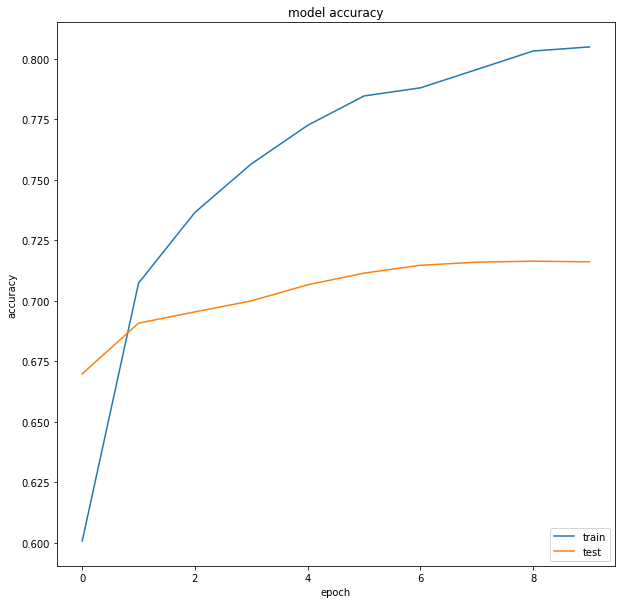

In [60]:
plt.figure(figsize=(10,10))
plt.plot(train_history.history['balanced_accuracy'])
plt.plot(train_history.history['val_balanced_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('Model Accuracy')
plt.show()


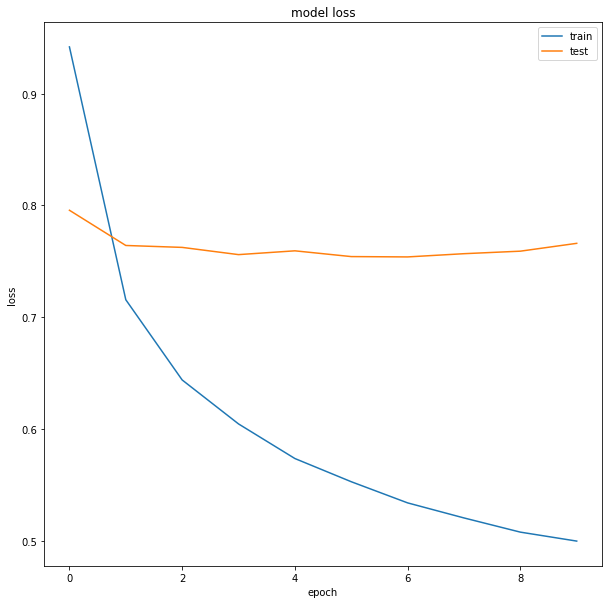

In [61]:
plt.figure(figsize=(10,10))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('Model Loss')
plt.show()
